In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import pickle
import joblib
from sklearn.preprocessing import normalize
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D
from tensorflow.keras import models, layers, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg16
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nanimalbirdfrogeda/test_labels.pkl
/kaggle/input/nanimalbirdfrogeda/train_features.pkl
/kaggle/input/nanimalbirdfrogeda/filename-noise.wav
/kaggle/input/nanimalbirdfrogeda/filename.wav
/kaggle/input/nanimalbirdfrogeda/__results__.html
/kaggle/input/nanimalbirdfrogeda/train_labels.pkl
/kaggle/input/nanimalbirdfrogeda/test_features.pkl
/kaggle/input/nanimalbirdfrogeda/train_noOS_labels.pkl
/kaggle/input/nanimalbirdfrogeda/train_noOS_features.pkl
/kaggle/input/nanimalbirdfrogeda/__notebook__.ipynb
/kaggle/input/nanimalbirdfrogeda/__output__.json
/kaggle/input/nanimalbirdfrogeda/custom.css
/kaggle/input/nanimalbirdfrogeda/__results___files/__results___15_0.png
/kaggle/input/nanimalbirdfrogeda/__results___files/__results___10_0.png
/kaggle/input/nanimalbirdfrogeda/__results___files/__results___24_0.png
/kaggle/input/nanimalbirdfrogeda/__results___files/__results___36_0.png
/kaggle/input/nanimalbirdfrogeda/__results___files/__results___21_0.png
/kaggle/input/nanimalbirdfrogeda/

In [2]:
X_train = joblib.load('/kaggle/input/nanimalbirdfrogeda/train_features.pkl')
X_test = joblib.load('/kaggle/input/nanimalbirdfrogeda/test_features.pkl')
print(X_train.shape,X_test.shape)

(1226, 128, 1000, 3) (304, 128, 1000, 3)


In [3]:
y_train = np.array(joblib.load('/kaggle/input/nanimalbirdfrogeda/train_labels.pkl'))
y_test = np.array(joblib.load('/kaggle/input/nanimalbirdfrogeda/test_labels.pkl'))
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123)
print(X_train.shape, y_train.shape,X_test.shape, y_test.shape,X_val.shape, y_val.shape)

(919, 128, 1000, 3) (919,) (304, 128, 1000, 3) (304,) (307, 128, 1000, 3) (307,)


# Distribution of species after augmentation (limited by RAM)

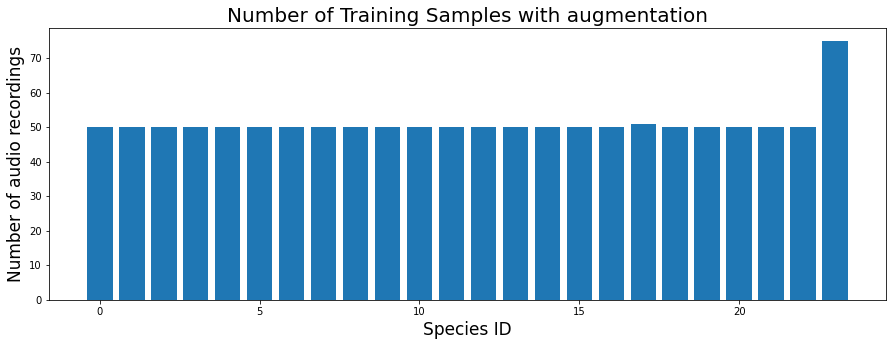

In [4]:
unique, counts = np.unique(np.concatenate((y_train,y_val)),return_counts=True)
values=dict(zip(unique,counts))
fig, ax = plt.subplots(figsize=(15,5))
barlist=plt.bar(values.keys(),values.values(), label='Minority samples')
plt.xlabel('Species ID', fontsize=17)
plt.ylabel('Number of audio recordings', fontsize=17)
plt.title('Number of Training Samples with augmentation', fontsize=20)
plt.show()

# Load transfer learning from ImageNet vgg16 model

In [5]:
input_shape=(128,1000,3)
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = layers.Flatten()(output)

vgg_model = Model(vgg.input, output)
vgg_model.trainable = True

for layer in vgg_model.layers:
    layer.trainable = True

vgg_model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 1000, 3)]    0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 1000, 64)     1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 1000, 64)     36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 500, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 500, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 500, 128)      147584    
______________________________________________________________

# Add vgg (a CNN) model to ANN model

In [6]:
input_shape=(128,1000,3)
CNNmodelvgg = models.Sequential()
CNNmodelvgg.add(vgg_model)
CNNmodelvgg.add(layers.Dense(1024, activation='relu'))
CNNmodelvgg.add(layers.Dropout(0.2))
CNNmodelvgg.add(layers.Dense(512, activation='relu'))
CNNmodelvgg.add(layers.Dense(24, activation='softmax'))
CNNmodelvgg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 63488)             14714688  
_________________________________________________________________
dense (Dense)                (None, 1024)              65012736  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 24)                12312     
Total params: 80,264,536
Trainable params: 80,264,536
Non-trainable params: 0
_________________________________________________________________


In [7]:
#Rescale features to between 0 and 1 so it fits with vgg data
Xmin=np.min(X_train)
Xmax=np.max(X_train)
X_train=(X_train-Xmin)/(Xmax-Xmin)
X_val=(X_val-Xmin)/(Xmax-Xmin)
X_test=(X_test-Xmin)/(Xmax-Xmin)

In [8]:
CNNmodelvgg.compile(optimizer=tf.keras.optimizers.Adam(lr=2e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = CNNmodelvgg.fit(X_train, y_train, epochs=30, 
                    validation_data=(X_val, y_val))

Epoch 1/30
29/29 [==============================] - 29s 761ms/step - loss: 3.2726 - accuracy: 0.0588 - val_loss: 3.1078 - val_accuracy: 0.0912
Epoch 2/30
29/29 [==============================] - 17s 602ms/step - loss: 2.9805 - accuracy: 0.1217 - val_loss: 2.4238 - val_accuracy: 0.1954
Epoch 3/30
29/29 [==============================] - 18s 607ms/step - loss: 2.4612 - accuracy: 0.2038 - val_loss: 2.1401 - val_accuracy: 0.3257
Epoch 4/30
29/29 [==============================] - 18s 605ms/step - loss: 2.0551 - accuracy: 0.3703 - val_loss: 1.9302 - val_accuracy: 0.4235
Epoch 5/30
29/29 [==============================] - 17s 604ms/step - loss: 1.8593 - accuracy: 0.4025 - val_loss: 1.7360 - val_accuracy: 0.4821
Epoch 6/30
29/29 [==============================] - 17s 605ms/step - loss: 1.6459 - accuracy: 0.4778 - val_loss: 1.5594 - val_accuracy: 0.5179
Epoch 7/30
29/29 [==============================] - 17s 600ms/step - loss: 1.4614 - accuracy: 0.5312 - val_loss: 1.4890 - val_accuracy: 0.5309

In [9]:
TrainLoss, Trainacc = CNNmodelvgg.evaluate(X_train,y_train)
TestLoss, Testacc = CNNmodelvgg.evaluate(X_test, y_test)
y_pred=CNNmodelvgg.predict(X_test)
print('TrainLoss: %f, Train accuracy %f, TestLoss: %f, Test Accuracy: %f ' %(TrainLoss,Trainacc,TestLoss,Testacc))
print('Confusion_matrix: ',tf.math.confusion_matrix(y_test, np.argmax(y_pred,axis=1)))

10/10 [==============================] - 2s 234ms/step - loss: 0.2254 - accuracy: 0.9507
TrainLoss: 0.299743, Train accuracy 0.895539, TestLoss: 0.225400, Test Accuracy: 0.950658 
Confusion_matrix:  tf.Tensor(
[[11  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 11  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 11  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 11  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 13  0  0

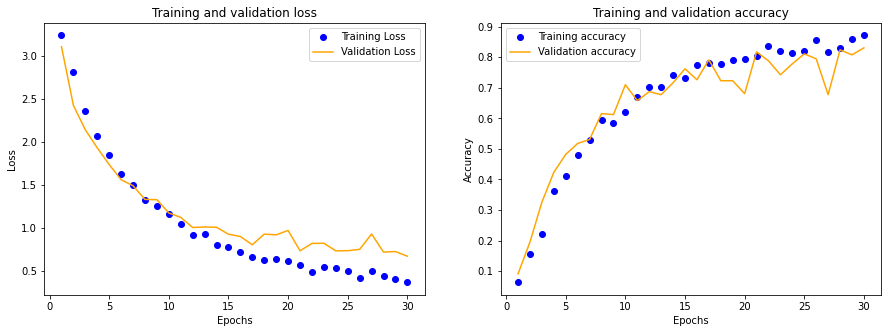

In [10]:
history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,31)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'bo',label='Training Loss')
ax1.plot(epochs,val_loss_values,'orange', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'bo', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'orange',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()